# Combining images and annotation into csv

In [ ]:

import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import os
from matplotlib import pyplot as plt

def sobel_edge_detection(img):
    """Enhanced Sobel edge detection with normalization"""
    if img.size == 0:
        return np.zeros_like(img, dtype=np.uint8)
    
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    
    if grad_mag.max() > 0:
        grad_mag = (grad_mag / grad_mag.max() * 255)
    return grad_mag.astype(np.uint8)

def preprocess_sonar_image(img_path):
    """Log-scaling with robust error handling"""
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not read image: {img_path}")
        if img.size == 0:
            raise ValueError(f"Empty image: {img_path}")
            
        img_float = img.astype(np.float32)
        img_log = np.log10(img_float + 1e-10)  # Avoid log(0)
        
        if np.isnan(img_log).any():
            raise ValueError(f"NaN values detected in {img_path}")
            
        img_min = np.nanmin(img_log)
        img_max = np.nanmax(img_log)
        
        if img_max > img_min:
            img_norm = 255 * (img_log - img_min) / (img_max - img_min)
        else:
            img_norm = np.zeros_like(img_log)
            
        return img_norm.astype(np.uint8)
    
    except Exception as e:
        print(f"Error preprocessing {img_path}: {str(e)}")
        return None

def parse_xml_annotations(xml_path):
    """XML parsing with complete error handling"""
    try:
        if not os.path.exists(xml_path):
            raise FileNotFoundError(f"XML file not found: {xml_path}")
            
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        objects = []
        for obj in root.findall('object'):
            try:
                bbox = obj.find('bndbox')
                if bbox is None:
                    continue
                    
                objects.append({
                    'name': obj.find('name').text if obj.find('name') is not None else 'unknown',
                    'xmin': max(0, int(bbox.find('xmin').text)),
                    'ymin': max(0, int(bbox.find('ymin').text)),
                    'xmax': max(0, int(bbox.find('xmax').text)),
                    'ymax': max(0, int(bbox.find('ymax').text))
                })
            except Exception as e:
                print(f"Error parsing object in {xml_path}: {str(e)}")
                continue
                
        metadata = {}
        try:
            metadata = {
                'range': safe_float(root.find('sonar/range')),
                'azimuth': safe_float(root.find('sonar/azimuth')),
                'elevation': safe_float(root.find('sonar/elevation'))
            }
        except Exception as e:
            print(f"Error parsing metadata in {xml_path}: {str(e)}")
            
        return objects, metadata
        
    except Exception as e:
        print(f"Error parsing {xml_path}: {str(e)}")
        return [], {}

def safe_float(element):
    """Safe conversion from XML element to float"""
    if element is None or element.text is None:
        return np.nan
    try:
        return float(element.text)
    except ValueError:
        return np.nan

def validate_roi(img, bbox):
    """Validate ROI coordinates and dimensions"""
    if img is None or img.size == 0:
        return False
        
    height, width = img.shape[:2]
    xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
    
    if xmin >= xmax or ymin >= ymax:
        return False
    if xmax <= 0 or ymax <= 0:
        return False
    if xmin >= width or ymin >= height:
        return False
        
    return True

def analyze_roi(img, bbox):
    """Robust ROI analysis with full error handling"""
    try:
        if not validate_roi(img, bbox):
            raise ValueError("Invalid ROI coordinates")
            
        roi = img[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
        if roi.size == 0:
            raise ValueError("Empty ROI")
            
        # Intensity statistics
        stats = {
            'mean_intensity': np.nanmean(roi),
            'intensity_std': np.nanstd(roi),
            'min_intensity': np.nanmin(roi),
            'max_intensity': np.nanmax(roi)
        }
        
        # Edge analysis
        edges = sobel_edge_detection(roi)
        edge_mask = edges > 30
        stats.update({
            'edge_density': np.nanmean(edge_mask),
            'edge_strength': np.nanmean(edges[edge_mask]) if np.any(edge_mask) else 0
        })
        
        return roi, edges, stats
        
    except Exception as e:
        print(f"Error analyzing ROI: {str(e)}")
        return None, None, None

def process_dataset(image_dir):
    """Main analysis pipeline with comprehensive logging"""
    results = []
    processed = 0
    skipped = 0
    
    image_dir = os.path.join(image_dir, 'images')
    annotation_dir = os.path.join(image_dir.replace('images', 'annotations'))
    
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(annotation_dir):
        raise FileNotFoundError(f"Annotation directory not found: {annotation_dir}")
    
    for img_file in sorted(os.listdir(image_dir)):
        if not img_file.endswith('.bmp'):
            continue
            
        try:
            img_path = os.path.join(image_dir, img_file)
            xml_path = os.path.join(annotation_dir, img_file.replace('.bmp', '.xml'))
            
            print(f"\nProcessing {img_file}...")
            img = preprocess_sonar_image(img_path)
            if img is None:
                skipped += 1
                continue
                
            objects, metadata = parse_xml_annotations(xml_path)
            if not objects:
                print(f"No valid objects found in {xml_path}")
                skipped += 1
                continue
                
            for obj in objects:
                roi, edges, stats = analyze_roi(img, obj)
                if stats is None:
                    skipped += 1
                    continue
                    
                results.append({
                    'image': img_file,
                    'object_name': obj['name'],
                    **metadata,
                    **stats
                })
                
                # Save visualizations
                os.makedirs('output', exist_ok=True)
                if roi is not None:
                    cv2.imwrite(f"output/{img_file}_roi_{obj['name']}.png", roi)
                if edges is not None:
                    cv2.imwrite(f"output/{img_file}_edges_{obj['name']}.png", edges)
                
                processed += 1
                
        except Exception as e:
            print(f"Fatal error processing {img_file}: {str(e)}")
            skipped += 1
    
    print(f"\nProcessing complete. Success: {processed}, Skipped: {skipped}")
    return pd.DataFrame(results)

if __name__ == "__main__":
    try:
        dataset_path = "dataset"  # Update with your path
        print("Starting analysis...")
        
        df = process_dataset(dataset_path)
        
        if not df.empty:
            # Save results
            df.to_csv("sonar_analysis_results.csv", index=False)
            
            # Generate plots
            plt.figure(figsize=(12, 7))
            for obj_name in df['object_name'].unique():
                subset = df[df['object_name'] == obj_name]
                plt.scatter(subset['range'], subset['mean_intensity'], label=obj_name, alpha=0.7)
            
            plt.title("Sonar Intensity Analysis")
            plt.xlabel('Range (m)')
            plt.ylabel('Mean Intensity (log-scaled)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig("intensity_vs_range.png", dpi=300)
            plt.close()
            
            print("\nAnalysis results saved to:")
            print("- sonar_analysis_results.csv")
            print("- intensity_vs_range.png")
            print("- ROI visualizations in /output directory")
            
            # Print summary
            print("\nSummary Statistics:")
            print(df.groupby('object_name').agg({
                'mean_intensity': ['mean', 'std'],
                'edge_density': ['mean', 'max']
            }))
        else:
            print("No valid data was processed. Check your input files.")
            
    except Exception as e:
        print(f"Fatal error in main execution: {str(e)}")

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('sonar_analysis_results.csv')

In [18]:
df.head()

,image,object_name,range,azimuth,elevation,mean_intensity,intensity_std,min_intensity,max_intensity,edge_density,edge_strength
0,00001.bmp,human body,10.0014,120.0,12.0,194.700000,58.136017,0,236,0.279437,143.935484
1,00002.bmp,human body,10.0007,120.0,12.0,201.200606,52.783960,0,249,0.227982,143.579458
2,00003.bmp,human body,10.0014,120.0,12.0,206.099523,47.551827,0,247,0.176385,142.471826
3,00004.bmp,human body,10.0014,120.0,12.0,211.267220,38.375531,0,244,0.133000,132.664830
4,00005.bmp,human body,10.0021,120.0,12.0,214.146567,33.920723,0,249,0.104042,130.274571


In [4]:
df.tail()

,image,object_name,range,azimuth,elevation,mean_intensity,intensity_std,min_intensity,max_intensity,edge_density,edge_strength
12291,07598.bmp,square cage,15.00030,120.0,20.0,181.098208,81.748647,0,243,0.478495,148.547191
12292,07599.bmp,human body,9.99816,120.0,20.0,214.584467,44.925752,0,253,0.144042,132.951613
12293,07600.bmp,human body,15.00230,120.0,20.0,191.396002,75.755396,0,254,0.393486,146.355316
12294,07600.bmp,ball,15.00230,120.0,20.0,186.347779,79.116246,0,251,0.437703,154.153465
12295,07600.bmp,circle cage,15.00230,120.0,20.0,196.230068,70.024679,0,245,0.337895,142.651728


In [19]:
df.describe()


,range,azimuth,elevation,mean_intensity,intensity_std,min_intensity,max_intensity,edge_density,edge_strength
count,12296.000000,12296.0,10691.000000,12296.000000,12296.000000,12296.000000,12296.000000,12296.000000,12296.000000
mean,12.341939,120.0,15.051539,207.847433,48.196872,6.832954,247.146389,0.232510,134.097870
std,3.568548,0.0,3.886108,16.122034,20.901682,37.624764,5.741755,0.164256,21.423097
min,5.998010,120.0,12.000000,155.135084,1.914854,0.000000,213.000000,0.002330,39.960526
25%,9.997750,120.0,12.000000,199.244789,35.499637,0.000000,244.000000,0.115696,129.676176
50%,12.002150,120.0,12.000000,209.653502,47.354827,0.000000,248.000000,0.189330,138.541338
75%,14.999100,120.0,20.000000,218.431450,62.741975,0.000000,252.000000,0.313798,146.140419
max,24.994200,120.0,20.000000,243.496812,94.744234,229.000000,255.000000,0.840741,229.250000


In [20]:
df.dtypes

image              object
object_name        object
range             float64
azimuth           float64
elevation         float64
mean_intensity    float64
intensity_std     float64
min_intensity       int64
max_intensity       int64
edge_density      float64
edge_strength     float64
dtype: object

In [21]:
df['object_name'].unique()

array(['human body', 'ball', 'circle cage', 'square cage', 'tyre',
       'metal bucket', 'cube', 'cylinder', 'plane', 'rov'], dtype=object)

In [22]:
df = df.drop(columns=['image', 'min_intensity', 'azimuth','elevation'])

In [23]:
df

,object_name,range,mean_intensity,intensity_std,max_intensity,edge_density,edge_strength
0,human body,10.00140,194.700000,58.136017,236,0.279437,143.935484
1,human body,10.00070,201.200606,52.783960,249,0.227982,143.579458
2,human body,10.00140,206.099523,47.551827,247,0.176385,142.471826
3,human body,10.00140,211.267220,38.375531,244,0.133000,132.664830
4,human body,10.00210,214.146567,33.920723,249,0.104042,130.274571
...,...,...,...,...,...,...,...
12291,square cage,15.00030,181.098208,81.748647,243,0.478495,148.547191
12292,human body,9.99816,214.584467,44.925752,253,0.144042,132.951613
12293,human body,15.00230,191.396002,75.755396,254,0.393486,146.355316
12294,ball,15.00230,186.347779,79.116246,251,0.437703,154.153465


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    df.corr(),
    annot=True,              # Display correlation values
    fmt=".2f",               # Format numbers to 2 decimal places
    cmap="coolwarm",         # Color scheme
    linewidths=0.5,          # Lines between cells
    linecolor='gray',        # Line color
    cbar_kws={"shrink": 0.8} # Smaller color bar
)
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [24]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'object_name' column
df['object_name'] = label_encoder.fit_transform(df['object_name'])

# Display the updated DataFrame
df.head()

,object_name,range,mean_intensity,intensity_std,max_intensity,edge_density,edge_strength
0,4,10.0014,194.700000,58.136017,236,0.279437,143.935484
1,4,10.0007,201.200606,52.783960,249,0.227982,143.579458
2,4,10.0014,206.099523,47.551827,247,0.176385,142.471826
3,4,10.0014,211.267220,38.375531,244,0.133000,132.664830
4,4,10.0021,214.146567,33.920723,249,0.104042,130.274571


In [25]:
X = df.drop(columns=['object_name'])
y = df['object_name']

In [26]:
X

,range,mean_intensity,intensity_std,max_intensity,edge_density,edge_strength
0,10.00140,194.700000,58.136017,236,0.279437,143.935484
1,10.00070,201.200606,52.783960,249,0.227982,143.579458
2,10.00140,206.099523,47.551827,247,0.176385,142.471826
3,10.00140,211.267220,38.375531,244,0.133000,132.664830
4,10.00210,214.146567,33.920723,249,0.104042,130.274571
...,...,...,...,...,...,...
12291,15.00030,181.098208,81.748647,243,0.478495,148.547191
12292,9.99816,214.584467,44.925752,253,0.144042,132.951613
12293,15.00230,191.396002,75.755396,254,0.393486,146.355316
12294,15.00230,186.347779,79.116246,251,0.437703,154.153465


In [27]:
y

0        4
1        4
2        4
3        4
4        4
        ..
12291    8
12292    4
12293    4
12294    0
12295    1
Name: object_name, Length: 12296, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Display the shapes of the training and testing sets


In [29]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_predit = rf_classifier.predict(X_test)

Accuracy: 0.7235772357723578
[[472  15  23   3  62   5   4   1  18  37]
 [ 16  85  17   5   9   0   0   0   1   2]
 [ 22   2 422  24   3   0   3   2  16  10]
 [  8   3  48  45   6   0   0   0   2   0]
 [ 62   4   1   1 164   0   0   0   3  10]
 [ 25   1   2   1   0  55   1   0  12   4]
 [  0   1   3   0   2   0 156   0   0   2]
 [  0   0   1   0   1   0   2 144   0   0]
 [ 34   1  17   0   8   5   0   2 114   6]
 [ 74   5   2   0   9   1   1   0   9 123]]


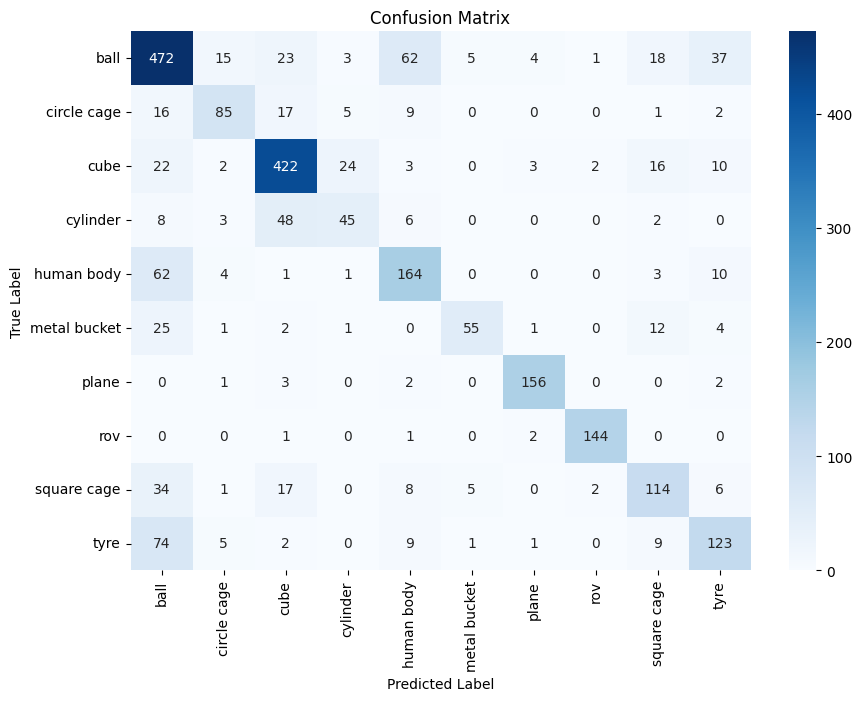

In [32]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

classification_report = accuracy_score(y_test, y_predit)
print(f"Accuracy: {classification_report}")
confusion_matrix = confusion_matrix(y_test, y_predit)
print(confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
# Set the figure size
plt.figure(figsize=(10, 7))
# Create a heatmap using seaborn
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# Set the title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Show the plot
plt.show()